In [0]:
import numpy
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10
from tensorflow.keras.models import load_model
import os
from numpy.random import randint
from matplotlib import pyplot

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.chdir("/content/drive/My Drive/deeplearning/")
!ls

cgan				      img_align_celeba_attractive_full.npz
gan_model.png			      latent_points_10000.npz
generated_faces_200.png		      latent_points_100.npz
ids_align_celeba_attractive_face.npz  latent_points_200.npz
ids_align_celeba_attractive_full.npz  list_attr_celeba.csv
img_align_celeba_attractive_face.npz  results


In [0]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

In [0]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [12]:
real_data_file = "img_align_celeba_attractive_face.npz"
images1 = numpy.load(real_data_file)["arr_0"]
images1 = images1[:10000]
images1 = (images1 - 127.5) / 127.5
images1 = (images1 + 1) / 2.0
print(images1.shape)
print(images1[0,:,:])
#print('Loaded', images1.shape, images2.shape)

(10000, 80, 80, 3)
[[[0.83529412 0.63137255 0.45490196]
  [0.8745098  0.6627451  0.49411765]
  [0.77647059 0.56078431 0.40784314]
  ...
  [0.56470588 0.43529412 0.33333333]
  [0.69411765 0.56078431 0.45882353]
  [0.78823529 0.67058824 0.56862745]]

 [[0.84705882 0.59215686 0.42745098]
  [0.74901961 0.49019608 0.3372549 ]
  [0.84313725 0.6        0.45490196]
  ...
  [0.69411765 0.56470588 0.46666667]
  [0.5254902  0.4        0.30196078]
  [0.65882353 0.54901961 0.45098039]]

 [[0.79215686 0.55294118 0.4       ]
  [0.85098039 0.62352941 0.49019608]
  [0.75294118 0.5372549  0.41568627]
  ...
  [0.88627451 0.74117647 0.64705882]
  [0.80784314 0.66666667 0.57254902]
  [0.55686275 0.41176471 0.31764706]]

 ...

 [[0.39215686 0.16862745 0.09411765]
  [0.29803922 0.07843137 0.03529412]
  [0.45882353 0.25490196 0.19607843]
  ...
  [0.90196078 0.61176471 0.4627451 ]
  [0.90588235 0.61960784 0.45098039]
  [0.89803922 0.61960784 0.43921569]]

 [[0.32156863 0.09803922 0.03137255]
  [0.41960784 0.2 

(10000, 100)
(10000, 80, 80, 3)
[[[0.2890522  0.23051628 0.1913681 ]
  [0.2429466  0.1791212  0.13674647]
  [0.24559042 0.18847671 0.1601567 ]
  ...
  [0.43446076 0.32253104 0.23832384]
  [0.46494558 0.33994684 0.2571798 ]
  [0.47053742 0.35829574 0.28482655]]

 [[0.2812007  0.22119501 0.16432688]
  [0.26235297 0.19582921 0.13567817]
  [0.24410361 0.18799931 0.14055237]
  ...
  [0.40553898 0.3008476  0.20794064]
  [0.39976826 0.28656685 0.19971803]
  [0.47442144 0.3472156  0.26268193]]

 [[0.30265677 0.22930154 0.16679162]
  [0.27766758 0.20333177 0.14274833]
  [0.26059628 0.19135845 0.15625662]
  ...
  [0.3959771  0.30200076 0.22612312]
  [0.33565527 0.24475804 0.17213124]
  [0.38718757 0.29008517 0.20746556]]

 ...

 [[0.31000805 0.09594217 0.04892936]
  [0.35091347 0.16299173 0.08985689]
  [0.19063449 0.05657843 0.03577238]
  ...
  [0.19994208 0.0880467  0.06105426]
  [0.23164979 0.1047172  0.07186764]
  [0.21694174 0.10218632 0.06592485]]

 [[0.2276819  0.09667531 0.05319872]
  [0.

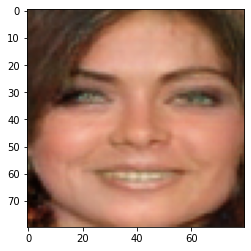

In [10]:
model = load_model("results/generator_model_200.h5")
CGAN_data_file = "latent_points_10000.npz"
latent_points = numpy.load(CGAN_data_file)["arr_0"]
print(latent_points.shape)
# generate images
labels = randint(1, 3, 10000)
images2 = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
images2 = (images2 + 1) / 2.0
print(images2.shape)
print(images2[0,:,:])
pyplot.imshow(images2[0, :, :])

In [13]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# load cifar10 images
#(images1, _), (images2, _) = cifar10.load_data()
#shuffle(images1)
#images1 = images1[:10000]
print('Loaded', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
print('Preprocessed', images1.shape, images2.shape)
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

Loaded (10000, 80, 80, 3) (10000, 80, 80, 3)
Scaled (10000, 299, 299, 3) (10000, 299, 299, 3)
Preprocessed (10000, 299, 299, 3) (10000, 299, 299, 3)
FID: 0.186
